In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# Try to load the data from the CSV file
try:
    # Try to load the data from the file - using comma separator (default for pandas)
    # Sample data shows no header row, so we specify header=None
    print("Attempting to load data from nonlinear_svm_data.csv...")
    data = pd.read_csv("nonlinear_svm_data.csv", header=0, sep=",")

    # From the sample, we know the format is [x, y, label]
    # Select the features (first two columns) and labels (last column)
    X = data.iloc[:, :-1].values  # All rows, all columns except the last
    y = data.iloc[:, -1].values  # All rows, only the last column

    # Convert labels to -1 and 1 if needed (SVM typically uses {-1, 1} labels)
    if np.min(y) == 0:
        print("Converting labels from {0,1} to {-1,1}...")
        y = 2 * y - 1  # Convert 0,1 to -1,1

    print(
        f"Data loaded successfully. Features shape: {X.shape}, Labels shape: {y.shape}"
    )

except FileNotFoundError:
    # Generate synthetic nonlinear data if the file is not found
    print("File not found. Generating synthetic nonlinear data...")
    X, y_binary = make_moons(n_samples=200, noise=0.2, random_state=42)

    # Convert labels to -1 and 1
    y = 2 * y_binary - 1  # Convert 0,1 to -1,1

    # Create a DataFrame to match the format of the provided sample
    synthetic_df = pd.DataFrame(
        {
            0: X[:, 0],  # x coordinate
            1: X[:, 1],  # y coordinate
            2: y_binary,  # original labels (0, 1)
        }
    )

    # Save the synthetic data to a CSV file for reference
    synthetic_df.to_csv("synthetic_nonlinear_svm_data.csv", index=False, header=False)

    print(
        f"Synthetic data generated. Features shape: {X.shape}, Labels shape: {y.shape}"
    )
    print("Sample of synthetic data saved to 'synthetic_nonlinear_svm_data.csv'")

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Display data statistics
print("\nData Statistics:")
print(f"Number of samples: {X.shape[0]}")
print(f"Number of features: {X.shape[1]}")
print(f"Number of classes: {len(np.unique(y))}")
print(
    f"Class distribution: {np.bincount(((y + 1) // 2).astype(int))}"
)  # Convert back to 0,1 for counting

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.001, random_state=42
)
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Attempting to load data from nonlinear_svm_data.csv...
Converting labels from {0,1} to {-1,1}...
Data loaded successfully. Features shape: (20, 2), Labels shape: (20,)

Data Statistics:
Number of samples: 20
Number of features: 2
Number of classes: 2
Class distribution: [12  8]
Training set size: 19
Test set size: 1


In [12]:
# Helper function to calculate hinge loss
def compute_hinge_loss(model, X, y):
    decision_values = model.decision_function(X)
    # For binary classification, hinge loss is max(0, 1 - y * f(x))
    losses = np.maximum(0, 1 - y * decision_values)
    return np.mean(losses)


# Function to visualize the decision boundary
def plot_decision_boundary(model, X, y, title, show_support_vectors=True):
    plt.figure(figsize=(10, 8))

    # Create a mesh grid
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Get predictions on the mesh grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Plot decision boundary and data points
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)

    # Scatter plot with colors based on labels
    scatter = plt.scatter(
        X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu_r, edgecolor="k", s=30
    )

    # Add a legend
    legend_labels = {-1: "Class -1 (originally 0)", 1: "Class 1 (originally 1)"}
    legend_elements = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=legend_labels[label],
            markerfacecolor=scatter.cmap(scatter.norm(label)),
            markersize=10,
        )
        for label in np.unique(y)
    ]
    plt.legend(handles=legend_elements, loc="upper right")

    # Highlight support vectors
    if show_support_vectors and hasattr(model, "support_vectors_"):
        plt.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            s=100,
            facecolors="none",
            edgecolor="k",
            label="Support Vectors",
        )

    plt.title(title)
    plt.xlabel("Feature 1 (x)")
    plt.ylabel("Feature 2 (y)")
    plt.tight_layout()

    return plt

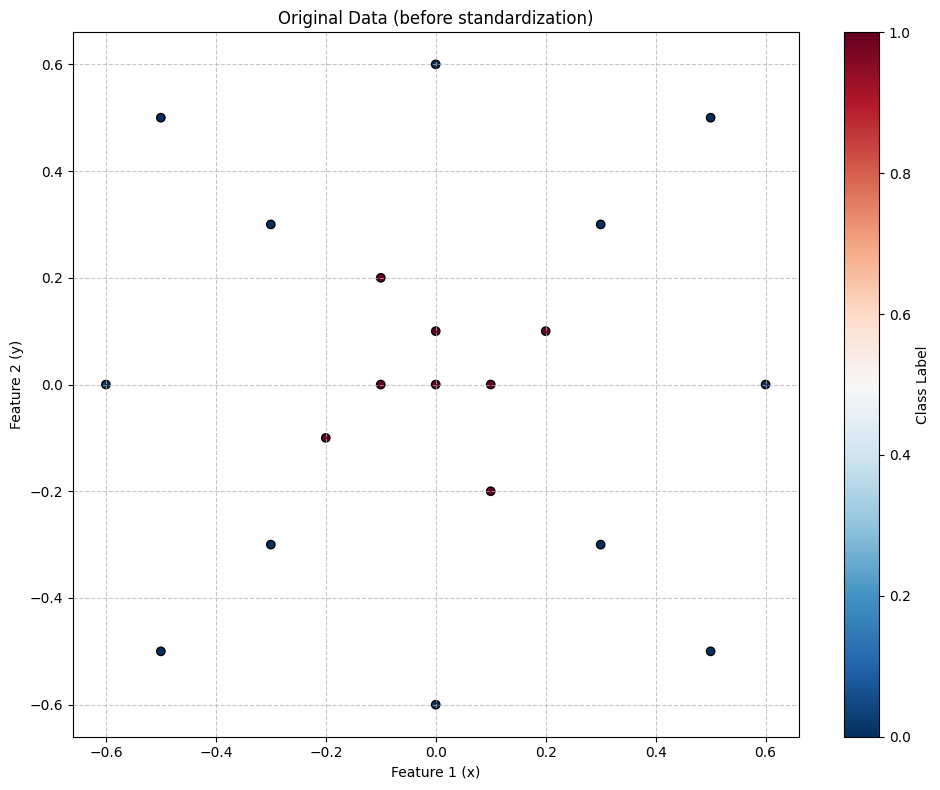

In [13]:
# Plot the original data (before standardization)
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=(y + 1) / 2, cmap=plt.cm.RdBu_r, edgecolor="k")
plt.title("Original Data (before standardization)")
plt.xlabel("Feature 1 (x)")
plt.ylabel("Feature 2 (y)")
plt.colorbar(label="Class Label")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.savefig("original_data.png")
# plt.close()


In [14]:
# Question 1: Linear SVM with different C values
print("\nQuestion 1: Linear SVM with different C values")
c_values = [1, 100, 1000]
linear_results = []

for c in c_values:
    # Train Linear SVM
    print(f"\nTraining Linear SVM with C={c}...")
    linear_svm = SVC(kernel="linear", C=c, random_state=42)
    linear_svm.fit(X_train, y_train)

    # Calculate training loss
    train_loss = compute_hinge_loss(linear_svm, X_train, y_train)

    # Store results
    linear_results.append(
        {
            "C": c,
            "Training Loss": train_loss,
            "Support Vectors": linear_svm.n_support_.sum(),
            "Training Accuracy": linear_svm.score(X_train, y_train),
        }
    )

    print(f"Training Loss: {train_loss:.4f}")
    print(f"Number of Support Vectors: {linear_svm.n_support_.sum()}")
    print(f"Training Accuracy: {linear_svm.score(X_train, y_train):.4f}")

    # Plot decision boundary
    plt_obj = plot_decision_boundary(
        linear_svm, X_train, y_train, f"Linear SVM (C={c}), Loss={train_loss:.4f}"
    )
    plt_obj.savefig(f"linear_svm_c{c}.png")
    plt.close()

# Display Linear SVM results
print("\nLinear SVM Results Summary:")
linear_df = pd.DataFrame(linear_results)
print(linear_df)


Question 1: Linear SVM with different C values

Training Linear SVM with C=1...
Training Loss: 0.7368
Number of Support Vectors: 17
Training Accuracy: 0.6316

Training Linear SVM with C=100...
Training Loss: 0.7368
Number of Support Vectors: 17
Training Accuracy: 0.6316

Training Linear SVM with C=1000...
Training Loss: 0.7369
Number of Support Vectors: 18
Training Accuracy: 0.6316

Linear SVM Results Summary:
      C  Training Loss  Support Vectors  Training Accuracy
0     1       0.736842               17           0.631579
1   100       0.736844               17           0.631579
2  1000       0.736882               18           0.631579


In [15]:
# Question 2: SVM with Gaussian kernel
print("\nQuestion 2: SVM with Gaussian Kernel")
a_values = [0.1, 1, 10]
rbf_results = []

for a in a_values:
    # Convert 'a' to gamma: gamma = 1/(2a²)
    gamma = 1 / (2 * (a**2))

    # Train RBF SVM
    print(f"\nTraining Gaussian Kernel SVM with a={a}, gamma={gamma:.6f}...")
    rbf_svm = SVC(kernel="rbf", C=1, gamma=gamma, random_state=42)
    rbf_svm.fit(X_train, y_train)

    # Calculate training loss
    train_loss = compute_hinge_loss(rbf_svm, X_train, y_train)

    # Store results
    rbf_results.append(
        {
            "a": a,
            "gamma": gamma,
            "Training Loss": train_loss,
            "Support Vectors": rbf_svm.n_support_.sum(),
            "Training Accuracy": rbf_svm.score(X_train, y_train),
        }
    )

    print(f"Training Loss: {train_loss:.4f}")
    print(f"Number of Support Vectors: {rbf_svm.n_support_.sum()}")
    print(f"Training Accuracy: {rbf_svm.score(X_train, y_train):.4f}")

    # Plot decision boundary
    plt_obj = plot_decision_boundary(
        rbf_svm,
        X_train,
        y_train,
        f"Gaussian Kernel SVM (a={a}, γ={gamma:.6f}), Loss={train_loss:.4f}",
    )
    plt_obj.savefig(f"gaussian_svm_a{a}.png")
    plt.close()

# Display Gaussian SVM results
print("\nGaussian Kernel SVM Results Summary:")
rbf_df = pd.DataFrame(rbf_results)
print(rbf_df)


Question 2: SVM with Gaussian Kernel

Training Gaussian Kernel SVM with a=0.1, gamma=50.000000...
Training Loss: 0.1536
Number of Support Vectors: 19
Training Accuracy: 1.0000

Training Gaussian Kernel SVM with a=1, gamma=0.500000...
Training Loss: 0.2079
Number of Support Vectors: 15
Training Accuracy: 1.0000

Training Gaussian Kernel SVM with a=10, gamma=0.005000...
Training Loss: 0.7363
Number of Support Vectors: 15
Training Accuracy: 0.6316

Gaussian Kernel SVM Results Summary:
      a   gamma  Training Loss  Support Vectors  Training Accuracy
0   0.1  50.000       0.153587               19           1.000000
1   1.0   0.500       0.207934               15           1.000000
2  10.0   0.005       0.736331               15           0.631579
